## Introduction to Spatial Analysis

Example of prediction of deforestation, using spatial location and some covariates.

**Data sources:**

Global Forest Change, University of Maryland<br>
https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.2.html

Humanitarian OpenStreetMap (roads data)<br>
https://data.humdata.org/dataset/hotosm_ken_roads

World Database on Protected Areas<br>
https://www.protectedplanet.net/

In [2]:
from sklearn import neighbors, ensemble, metrics
import sklearn
import scipy
import scipy.ndimage
%pylab inline

Populating the interactive namespace from numpy and matplotlib


First we read in the data, and specify some helper functions.

In [3]:
with np.load('data/ke_tz_ug_spatialdata.npz') as datafile:
    roads = datafile['roads']
    extent = datafile['extent']
    protectedareas = datafile['protectedareas']
    lossyear = datafile['lossyear']
    treecover2000 = datafile['treecover']
    geotransform = datafile['geotransform']
    
def treecover_at_year(year):
    '''Return the tree cover for each pixel at the given year (2000-2017).
    Year is specified as an int between 0 and 17'''
    
    if year==0:
        return treecover2000
    cover = treecover2000.copy()
    cover[np.where(np.logical_and(lossyear>0, lossyear<=year))] = 0
    return cover

def loss_in_year(year):
    '''Return the pixels corresponding to deforested areas in the given year (2001-2016).
    Year is specified as an int between 1 and 16'''
    
    loss = lossyear==year
    return loss.astype('float') 

def lonlat2XY(pt):
    '''Convert from a (longitude,latitude) tuple to (x,y) position in pixels.'''
    x = int((pt[0] - geotransform[0])/geotransform[1])
    y = int((pt[1] - geotransform[3])/geotransform[5])
    return np.array([x,y])

def XY2lonlat_sgl(pt):
    '''Convert from an (x,y) position in pixels to (longitude,latitude).'''
    xoff, a, b, yoff, d, e = geotransform
    lon = a * pt[0] + b * pt[1] + xoff
    lat = d * pt[0] + e * pt[1] + yoff
    return np.array([lon, lat])

def XY2lonlat(pt):
    '''Convert from x,y image coordinates to longitude,latitude.
    pt should be Nx2 array of x,y positions'''
    xoff, a, b, yoff, d, e = geotransform
    lon = a * pt[:,0] + b * pt[:,1] + xoff
    lat = d * pt[:,0] + e * pt[:,1] + yoff
    return np.array([lon, lat]).transpose()

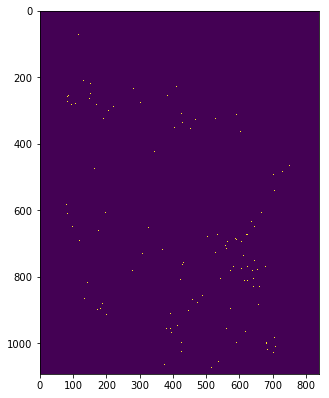

In [4]:
imshow(loss_in_year(10))
gcf().set_size_inches(5,7)

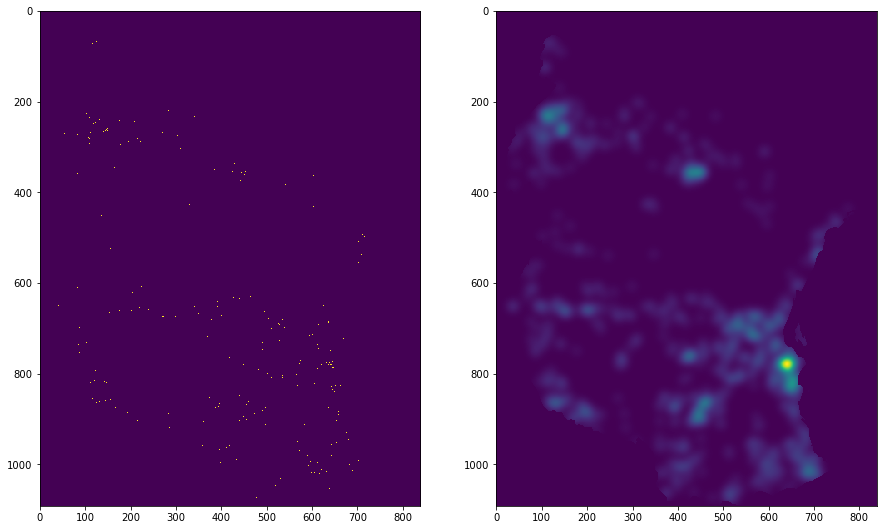

In [5]:
loss_density = scipy.ndimage.filters.gaussian_filter(loss_in_year(10), 11, mode='nearest') * extent

# Slower alternative, defined below
#loss_density = kernel_density(loss_in_year(15), length_scale_km=5)

subplot(121)
imshow(loss_in_year(10))
subplot(122)
imshow(loss_density)
gcf().set_size_inches(15,10)

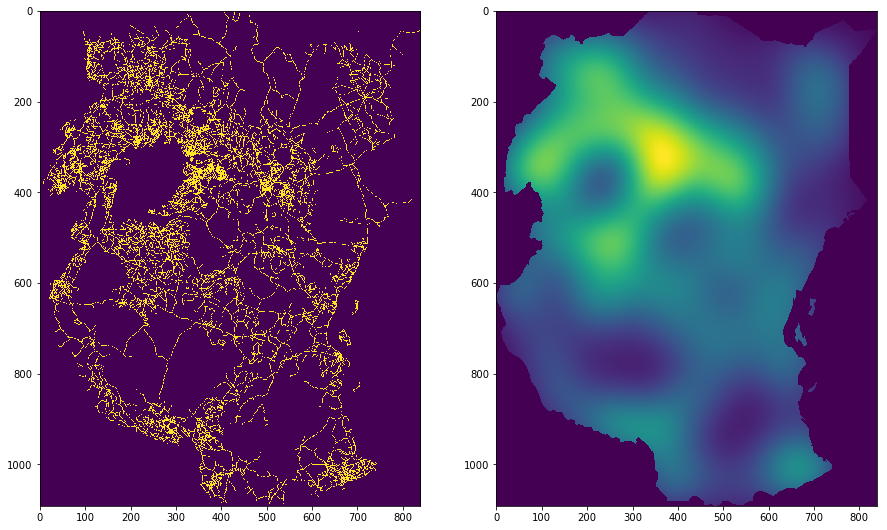

In [6]:
roads_density = scipy.ndimage.filters.gaussian_filter(roads, 50, mode='nearest') * extent

# Alternative calculation
#roads_density = kernel_density(roads, length_scale_km=30, ll_cutoff=-10)

subplot(121)
imshow(roads)
subplot(122)
imshow(roads_density)
gcf().set_size_inches(15,10)

## Prediction of deforestation

Start by tring to predict based only on the deforestation locations in the previous year

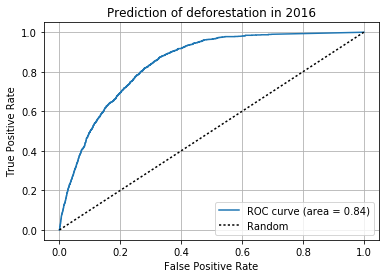

In [7]:

target_year = 16

# Which are the pixels inside the region of interest?
idx1,idx2 = np.where(extent)

# We want to predict the loss in the target year
y_test = loss_in_year(target_year)[idx1,idx2]

# Start with predictions which is simply the smoothed forest loss from the previous year
loss_density = scipy.ndimage.filters.gaussian_filter(loss_in_year(target_year-1), 11, mode='nearest') * extent
y_pred = loss_density[idx1,idx2]

# Evaluate these predictions
fpr,tpr,thresholds = sklearn.metrics.roc_curve(y_test,y_pred)
roc_auc = sklearn.metrics.roc_auc_score(y_test,y_pred)

# Plot the results
plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
               ''.format(roc_auc))

plt.plot([0,1],[0,1],'k:',label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.title('Prediction of deforestation in {}'.format(2000+target_year))

## Prediction with covariates

Now try the prediction with some other covariates: road density, protected area status, forest cover.

In [8]:
target_year = 15

# Which are the pixels inside the region of interest?
idx1,idx2 = np.where(extent)

# We want to predict the loss in the target year
y_train = loss_in_year(target_year)[idx1,idx2]

# Calculate some more covariates
loss_density = 0*scipy.ndimage.filters.gaussian_filter(loss_in_year(target_year-1), 11, mode='nearest') * extent
road_density = scipy.ndimage.filters.gaussian_filter(roads, 7, mode='nearest') * extent

X_train = np.vstack((loss_density[idx1,idx2],
                     road_density[idx1,idx2],
                     protectedareas[idx1,idx2],
                     treecover_at_year(target_year-1)[idx1,idx2])).transpose()

clf = ensemble.GradientBoostingClassifier()
%time clf.fit(X_train,y_train)

Wall time: 42.9 s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

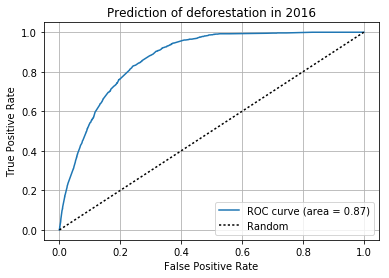

In [9]:
target_year = 16

loss_density = scipy.ndimage.filters.gaussian_filter(loss_in_year(target_year-1), 11, mode='nearest') * extent

X_test = np.vstack((loss_density[idx1,idx2],
                    road_density[idx1,idx2],
                    protectedareas[idx1,idx2],
                    treecover_at_year(target_year-1)[idx1,idx2])).transpose()

y_pred = clf.predict_proba(X_test)[:,1]

y_test = loss_in_year(target_year)[idx1,idx2]

# Evaluate these predictions
fpr,tpr,thresholds = sklearn.metrics.roc_curve(y_test,y_pred)
roc_auc = sklearn.metrics.roc_auc_score(y_test,y_pred)

# Plot the results
plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
               ''.format(roc_auc))

plt.plot([0,1],[0,1],'k:',label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.title('Prediction of deforestation in {}'.format(2000+target_year))

Have a look at the deforestation forecast, with the most recent data available

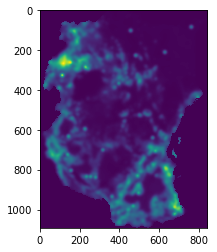

In [10]:
loss_density = scipy.ndimage.filters.gaussian_filter(loss_in_year(16), 11, mode='nearest') * extent

X_test = np.vstack((loss_density[idx1,idx2],
                    road_density[idx1,idx2],
                    protectedareas[idx1,idx2],
                    treecover_at_year(target_year-1)[idx1,idx2])).transpose()

y_pred = clf.predict_proba(X_test)[:,1]

prediction = np.zeros(extent.shape)
prediction[idx1,idx2] = y_pred

# For visualisation, smooth out the points a bit to make it easier to see
prediction_smoothed = scipy.ndimage.filters.gaussian_filter(prediction, 7, mode='nearest') * extent
imshow(prediction_smoothed)

If you have the gdal library installed, then the predictions can be written to a GeoTIFF (for viewing in QGIS etc).

In [11]:
import gdal
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(
    'data/deforestation_forecast.tif',
    prediction_smoothed.shape[1],
    prediction_smoothed.shape[0],
    1,
    gdal.GDT_Float32)
dataset.SetGeoTransform(geotransform)
band = dataset.GetRasterBand(1)
band.WriteArray(prediction_smoothed)
band.SetNoDataValue(0)
dataset.FlushCache()
dataset = None

ModuleNotFoundError: No module named 'gdal'

### Exercises

Calculate the overall forest loss in Kenya, Tanzania and Uganda from 2000-2016. Is deforestation increasing or reducing?

Can you alter the model, using any methods for regression you know, to get more accurate predictions?

Find the areas with the highest deforestation risk this year, and use XY2lonlat() to get their locations. Where are they?

## More info

### Better models

Below is another method to calculate smoothed density estimates - a bit less hacky than using the Gaussian blur filter, and can explicitly use longitude/latitude coordinates, but much slower to compute.

For a more in depth model of spatiotemporal prediction, see the R Spatiotemporal package:<br>
https://cran.r-project.org/web/packages/SpatioTemporal/vignettes/ST_intro.pdf

### Other remote sensing data

Shapefiles corresponding to the datasets in this exercise, e.g. to explore in QGIS<br>
https://www.dropbox.com/s/s61jzpgbbs29rpn/dsa2018_spatial_datasets.zip?dl=1

EUMeteoStat, hourly weather satellite data<br>
http://oiswww.eumetsat.org/IPPS/html/MSGIODC/RGB/NATURALCOLOR/CENTRALAFRICA/index.htm

Africa remote sensing data, including rainfall and vegetation strength<br>
https://earlywarning.usgs.gov/fews/search/Africa


In [ ]:
def kernel_density(features, length_scale_km=50, feature_samples=1000, ll_cutoff=-15):
    
    # Pixel positions of features
    y_idx_feature,x_idx_feature = np.where(features)

    if feature_samples>0 and feature_samples<len(y_idx_feature):
        samples = np.random.choice(range(len(y_idx_feature)),feature_samples)
        y_idx_feature = y_idx_feature[samples]
        x_idx_feature = x_idx_feature[samples]

    # Longitude/latitude positions of roads
    features_lonlat = XY2lonlat(np.array((x_idx_feature,y_idx_feature)).transpose())

    # Fit a kernel density estimator to the road locations
    kde = neighbors.KernelDensity(length_scale_km/111.11,kernel='exponential')
    kde.fit(features_lonlat)

    # Calculate the density estimate across the map
    feature_density = np.ones(features.shape)*ll_cutoff
    y_idx,x_idx = np.where(extent)

    # TODO: add optional downsampling here to speed up the calculation
    
    extent_lonlat = XY2lonlat(np.array((x_idx,y_idx)).transpose())
    feature_density[y_idx,x_idx] = kde.score_samples(extent_lonlat)
    
    # We don't usually care about very low log likelihoods
    if feature_density.min()<ll_cutoff:
        feature_density[feature_density<ll_cutoff] = ll_cutoff
    
    return feature_density
    